In [1]:
#Packages for dataframe manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Packages for natural language processing
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

#Updating default settings
pd.set_option('display.max_columns', 1000)

In [2]:
#Go through our corpus and remove words at a later time
#from nltk.corpus import stopwords
#stopwords.words('english')

In [3]:
dataset = pd.read_pickle('other_xmltodict_all_major_fields.pkl')

In [4]:
### Drop the rows with no values in section_bodies
dataset = dataset[dataset['section_bodies'] != 'Null']
print("Without Null rows: " + str(len(dataset)))

Without Null rows: 2520


In [5]:
#only keep the SOR and CRC...SI are not included in the scope
dataset['regulation_type'].value_counts()

SOR     2265
SI       246
Null       9
Name: regulation_type, dtype: int64

In [6]:
dataset = dataset[dataset['regulation_type']!= 'SI']

In [7]:
#What are the different types of acts? This will be helpful for industry tagging
## Note that in the xml extraction, some of the original entries for enabling authority were lists, requires cleaning

list_enabling_authority = list(dataset['enabling_authority'])
clean_acts = []

for i in range(0,len(list_enabling_authority)):
    clean_acts.append(str(list_enabling_authority[i]))

dataset['list_enabling_authority'] = clean_acts

In [8]:
#counting the number of times each act appears 
dataset_act_count = pd.DataFrame(dataset['list_enabling_authority'].value_counts().reset_index())

#renaming the dataframe
dataset_act_count.rename({'list_enabling_authority':'Act_Count', 'index':'Act_Title'},inplace=True)

In [9]:
dataset_act_count.rename(columns={'list_enabling_authority':'Act_Count', 'index':'Act_Title'},inplace=True)

In [10]:
print (len(dataset_act_count))

363


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

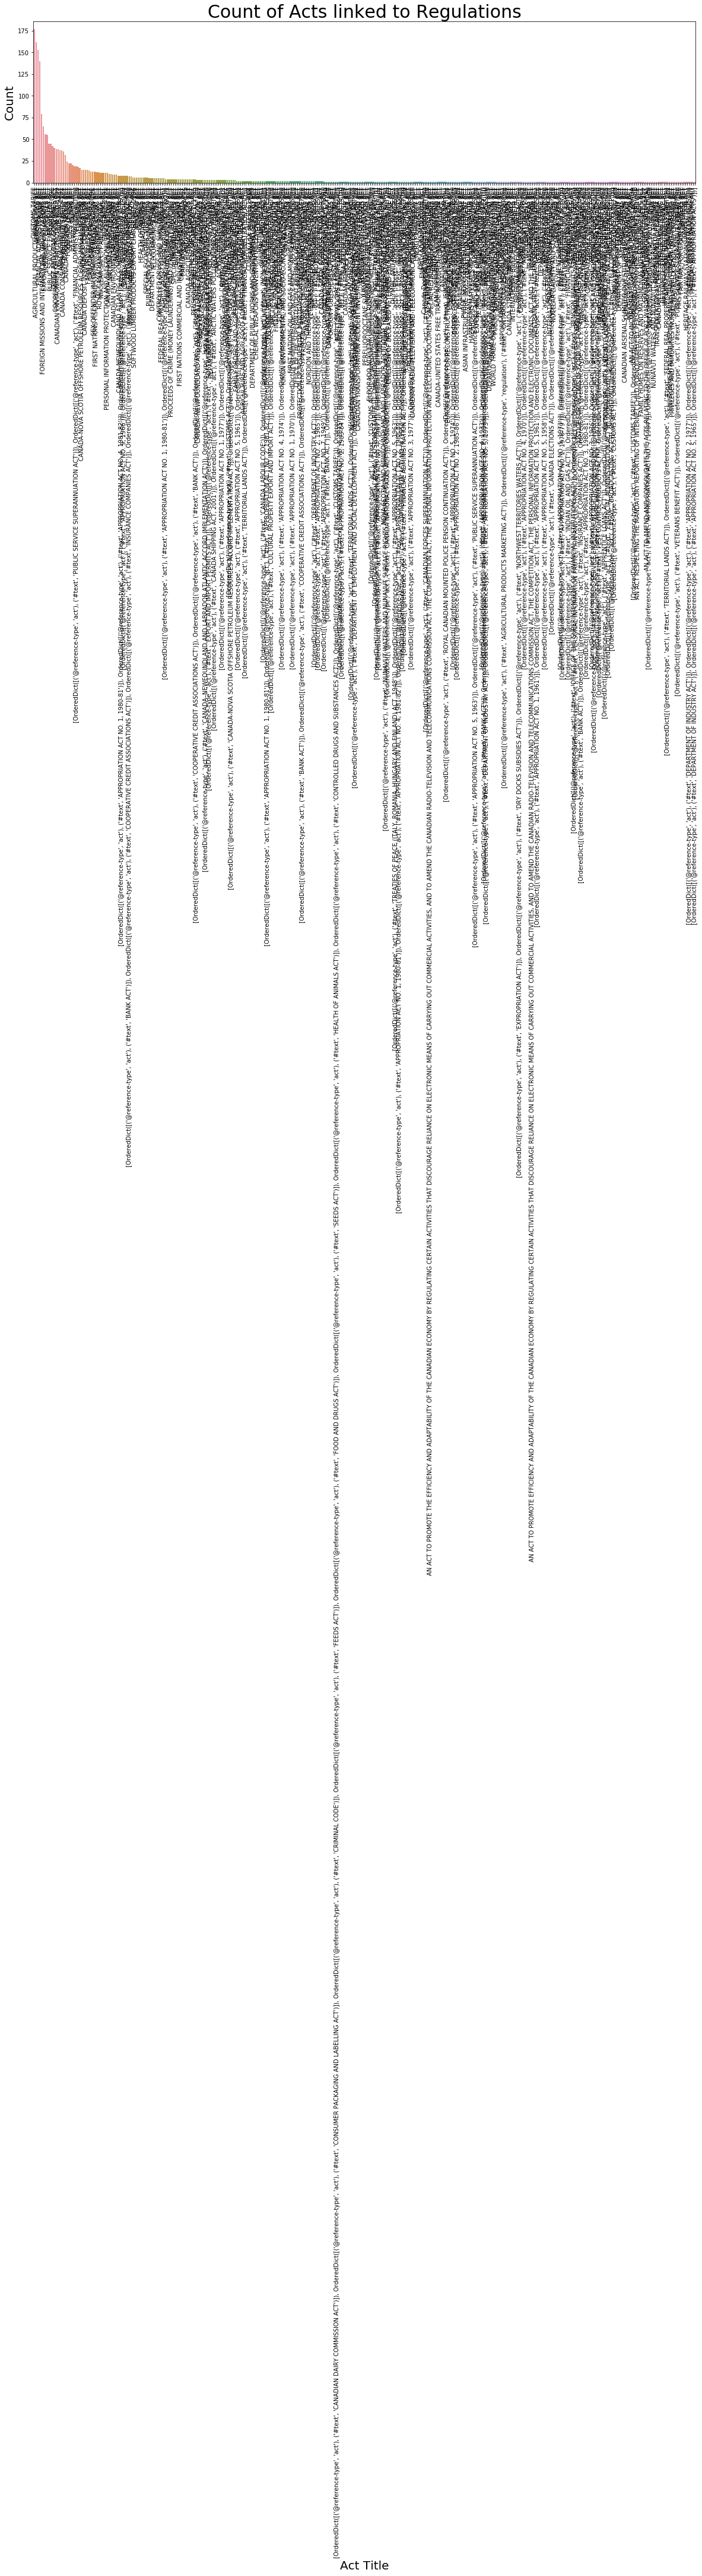

In [96]:
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(x='Act_Title',y='Act_Count',data=dataset_act_count)
ax.set_title('Count of Acts linked to Regulations',size=30)
ax.set_xlabel('Act Title', size=20)
ax.set_ylabel('Count',size=20)
plt.xticks(rotation=90)

In [31]:
#dataset_act_count.to_excel('Regs_Acts_Counts_v1.xlsx')

## 1. Creating the Corpus & Sparse Matrix

In [32]:
def make_corpus(dataset, column):
    '''This function reads in a pandas dataframe (dataset) and the column name (e.g. 'text_column'). 
    Then it strips all punctuation, makes it lower case, tokenizes it, and removes english stopwords. 
    Finally it returns two lists (either directly or via tuple unpacking. the first is the documents
    without stopwords; the second is the documents stemmed via porterstemmer.
    '''
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    stop_words = set(stopwords.words('english'))
    import string 
    import sys
    translator = str.maketrans('', '', string.punctuation)
    import re
    from nltk.stem import PorterStemmer
    ps = PorterStemmer()
    filtered_text_list = []
    stemmed_text_list = []
    for i in range (0, len(dataset)):
        text = dataset.iloc[i][column].lower().translate(translator)
        text = re.sub('\n', ' ', text)
        word_tokens = word_tokenize(text) 
        filtered_text = [w for w in word_tokens if not w in stop_words]
        filtered_text = []
        for w in word_tokens:
            if w not in stop_words:
                filtered_text.append(w)
        stemmed_text = []
        for w in filtered_text:
            stemmed_text.append(ps.stem(w))
        filtered_text_list.append(str(filtered_text).translate(translator))
        stemmed_text_list.append(str(stemmed_text).translate(translator))
        #sys.stdout.write("\r" + "Creating Corpus.. Processing Record: " + str(i+1) + " of " + str(len(dataset)))
        #sys.stdout.flush()
    #print("\nDONE!")
    return filtered_text_list, stemmed_text_list

In [33]:
filtered_text, stemmed_text = make_corpus(dataset,'section_bodies')

In [34]:
cv = CountVectorizer()
X = cv.fit_transform(stemmed_text).toarray()

In [35]:
X.shape

(2274, 12595)

In [36]:
df_sparse = pd.DataFrame(X, columns = cv.get_feature_names())

## 2. Cleaning the Sparse Matrix

In [37]:
features = pd.Series(df_sparse.columns)

##### Removing features which contain a number

In [38]:
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

In [39]:
#remove all the features which are numeric
index = features.map(hasNumbers)

In [40]:
#how many are numeric?
index.value_counts()

False    7512
True     5083
dtype: int64

In [41]:
#list of features to drop
dropped_features = features[index]

In [42]:
len(dropped_features)

5083

In [43]:
#Drop it like its hot
df_sparse = df_sparse.drop(columns=dropped_features)

In [44]:
df_sparse.shape

(2274, 7512)

##### Removing the helping verbs

In [45]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

In [46]:
#There are 23 helping verbs in total
helping_verbs = ['am', 'is', 'are', 'was', 'were', 'being', 'been', 'be', 'have', 'has', 'had', 'do', 'does', 
                 'did', 'will', 'would', 'shall', 'should', 'may', 'might', 'must', 'can', 'could']

#Obtain the stemed version of each word
helping_verbs_stemmed = []
for verb in helping_verbs:
    helping_verbs_stemmed.append(ps.stem(verb).lower())

In [47]:
#Which helping verbs are in the sparse matrix?
helping_verbs_stemmed_drop = []

cols = list(df_sparse.columns)

for verb in helping_verbs_stemmed:
    if verb in cols:
        helping_verbs_stemmed_drop.append(verb)
        
print (helping_verbs_stemmed_drop)

['will', 'would', 'shall', 'may', 'might', 'must', 'could']


In [48]:
#Remove the helping verbs and check the outcomes
print ('shape before dropping helping verbs:' + str(df_sparse.shape))

df_sparse = df_sparse.drop(columns=helping_verbs_stemmed_drop)

print ('shape after dropping helping verbs:' + str(df_sparse.shape))

shape before dropping helping verbs:(2274, 7512)
shape after dropping helping verbs:(2274, 7505)


##### Graphing the word counts

In [76]:
df_sparse_t = df_sparse.transpose()

In [77]:
df_sparse_t['totals'] = df_sparse_t.sum(axis=1)

In [78]:
df_sparse_t = df_sparse_t.reset_index()

In [79]:
df_sparse_t = df_sparse_t.sort_values(by='totals', ascending=False)

In [ ]:
fig, ax = plt.subplots(figsize=(30, 10))
sns.barplot(y='totals',x='index', data=df_sparse_t)
ax.set_title('Total Count of Stemmed Words',size=20)
ax.set_xlabel('Word',size=15)
ax.set_ylabel('Total Count across Regs',size=15)
plt.xticks(rotation=90)

## 3. TF-IDF Vectorizer

In [23]:
#convert the count matrix to tf-idf representation
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(df_sparse).toarray()

In [24]:
#df_sparse = pd.DataFrame(tfidf, columns = cols)

In [25]:
feature_names = df_sparse.columns

# find maximum value for each of the features over all of dataset:
max_val = df_sparse.max(axis=0).ravel()

#sort weights from smallest to biggest and extract their indices 
sort_by_tfidf = max_val.argsort()

print("Features with lowest tfidf:\n{}".format(
      feature_names[sort_by_tfidf[:20]]))

print("\nFeatures with highest tfidf: \n{}".format(
      feature_names[sort_by_tfidf[-20:]]))

Features with lowest tfidf:
Index(['northwestel', 'speech', 'premiumpay', 'spednic', 'spectat',
       'discredit', 'prepaidport', 'discriminatori', 'sphere', 'iran', 'ipc',
       'ioniz', 'ionexchang', 'dish', 'dishonest', 'sovereignti', 'ioc',
       'sparkler', 'discomfort', 'discolor'],
      dtype='object')

Features with highest tfidf: 
Index(['appeal', 'particular', 'system', 'categori', 'licenc', 'produc',
       'hazard', 'act', 'particip', 'certif', 'ferri', 'store', 'vessel',
       'subsect', 'dive', 'suppli', 'invest', 'food', 'plan', 'explos'],
      dtype='object')


## 4. Latent Semantic Analysis

In [26]:
lsa = TruncatedSVD(n_components = 100, algorithm='arpack', random_state=0)
dtm_lsa = lsa.fit_transform(tfidf)

In [27]:
#What are the top components of each concept?
for i, comp in enumerate(lsa.components_):
    terms_in_comp = zip(cols,comp)
    sorted_terms = sorted(terms_in_comp, key=lambda x: x[1], reverse=True)[:10]
    print('Concept %d:' %i)
    
    for term in sorted_terms:
        print(term[0])
    print (' ')
    

Concept 0:
forbid
come
datum
regi
registrar
lamproom
optim
nwtsoirc
secretari
perpendicular
 
Concept 1:
lamproom
nwtsoirc
plywood
element
airport
build
stripe
appli
grown
oviduct
 
Concept 2:
board
act
perpendicular
subrul
marker
commod
author
poult
secretari
purg
 
Concept 3:
board
commod
marker
poult
exempt
protrud
interpret
tp
optim
exponentialtimeaverag
 
Concept 4:
immov
prisonerofwar
articl
convent
remarri
canada
ordinari
optim
extens
grandpar
 
Concept 5:
remarri
grandpar
gone
implic
condit
optim
custodian
pave
paddleboat
dustproof
 
Concept 6:
compani
bank
entireti
remarri
hoist
grandpar
insul
invert
acquir
subsidiari
 
Concept 7:
gone
station
canada
implic
registrar
chapter
exponentialtimeaverag
come
forbid
enabl
 
Concept 8:
permafrost
exponentialtimeaverag
gone
author
regi
implic
optim
compani
scare
bank
 
Concept 9:
insul
proclaim
miner
loadcarri
lever
applic
board
lend
compani
prioriti
 
Concept 10:
column
servant
scare
proclaim
lever
italic
amount
paus
font
pave
 
Concep

In [34]:
list_concepts = []
    
for i in range(0,len(lsa.components_)):
    list_concepts.append('Concept %d' %i)
    
df_lsa = pd.DataFrame(dtm_lsa, columns=list_concepts)

#df_lsa

###### Document Similarity using LSA

In [35]:
df_norm = Normalizer(copy=False).fit_transform(dtm_lsa)

In [36]:
similarity = np.asarray(np.asmatrix(df_norm) * np.asmatrix(df_norm).T)
regs = list(dataset['instrument_number'])

In [37]:
df_heatmap = pd.DataFrame(similarity,index=regs, columns=regs)

In [38]:
#df_heatmap

## 5. Extracting the highly similar documents

In [40]:
#minimum score/value for regulations to be considered similar
thresh_min = 0.95

#max score/value, above which regulations are the same document
thresh_max = 0.999999

In [48]:
#column names 
regs = df_heatmap.columns

#master list of similar regs to append to
similar_regs = []

#analyze each column's scores one at a time
for reg_1 in regs:
    reg_1_scores = df_heatmap[reg_1]
    
    #track the index value (integer) which meet the criteria
    index_value = 0
    list_index = []

    for score in reg_1_scores:
        if (score > thresh_min and score < thresh_max):
            list_index.append(index_value)
        index_value += 1
    
    #track the reg pairs which exceed the criteria - check for duplicates
    for i in list_index:
        reg_2 = df_heatmap.index[i]
        
        if [reg_2,reg_1] not in similar_regs:
            similar_regs.append([reg_1,reg_2])

##### Checking the outputs

Given that the formula for the number of possible cominations where order doesn't matter:

C(n,r)=n!/(n−r)!r!

In [65]:
import math
comb = int(math.factorial(len(df_heatmap))/(math.factorial((len(df_heatmap)-2))*math.factorial(2)))
print ('total combinations is: ' + str(comb))

total combinations is: 2584401


In [73]:
print ('Number of reg pairs over the threshold: ' + str(len(similar_regs)))
print ('Percent of reg pairs over the threshold: ' + str(len(similar_regs)/comb*100) + '%')

Number of reg pairs over the threshold: 4880
Percent of reg pairs over the threshold: 0.18882518618434213%


## Which Lebels in the Regs are Most Similar?

In [80]:
#convert the nested list into a DataFrame
reg_1 = []
reg_2 = []

for pair in similar_regs:
    reg_1.append(pair[0])
    reg_2.append(pair[1])

d = {'Reg_1':reg_1, 'Reg_2':reg_2}    
df_similar = pd.DataFrame(data=d)

In [81]:
df_similar

,Reg_1,Reg_2
0,SOR/93-293,SOR/93-522
1,SOR/93-293,SOR/2002-138
2,SOR/93-293,SOR/95-558
3,SOR/93-293,SOR/78-771
4,SOR/93-293,SOR/93-524
5,SOR/93-293,"C.R.C., c. 83"
6,SOR/93-293,SOR/87-706
7,SOR/93-293,SOR/93-74
8,SOR/93-293,SOR/80-803
9,SOR/93-293,SOR/93-409


# Testing how to compare Labels - LSA

In [668]:
#Set the target regs to compare
reg1 = 'SOR/93-293'
reg2 = 'SOR/91-253'


In [669]:
#Locate the target regs from the dataframe
df_reg1 = dataset[dataset['instrument_number']==reg1]
df_reg2 = dataset[dataset['instrument_number']==reg2]

#Extract the body text from both regs
reg1_body = list(df_reg1['section_bodies'])
reg2_body = list(df_reg2['section_bodies'])

#Extract the labels from both regs
reg1_labels = list(df_reg1['section_labels'])
reg2_labels = list(df_reg2['section_labels'])

#extract all the text between singular quotes because each set of quoates is a new section (or subsection) 
quoted  = re.compile("'[^']*'")
reg1_body_clean = []
reg2_body_clean = []

for section in quoted.findall(str(reg1_body)):
    reg1_body_clean.append(section)
    
for section in quoted.findall(str(reg2_body)):
    reg2_body_clean.append(section)

#Extract the section labels for each regs body (note the values are also stored between quotes)
## Also note that none include 'Label 1' so it must be added
reg1_labels_clean = [reg1 + ' Label: 1']
reg2_labels_clean = [reg2 + ' Label: 1']

for num in quoted.findall(str(reg1_labels)):
    reg1_labels_clean.append(reg1 + ' Label: ' + num.strip("'"))
    
for num in quoted.findall(str(reg2_labels)):
    reg2_labels_clean.append(reg2 + ' Label: ' + num.strip("'"))
    
#Combine the body and label lists and convert to a dataframe 
combined_body = []
combined_body.extend(reg1_body_clean)
combined_body.extend(reg2_body_clean)

combined_labels = []
combined_labels.extend(reg1_labels_clean)
combined_labels.extend(reg2_labels_clean)

df_similar_regs_label = pd.DataFrame(data={'Reg_Label':combined_labels, 'Text':combined_body})

In [670]:
#Apply the corpus creating function
filtered_text_label, stemmed_text_label = make_corpus(df_similar_regs_label,'Text')

#Create the initial sparse matrix
cv_label = CountVectorizer()
X_label = cv_label.fit_transform(stemmed_text_label).toarray()
df_sparse_label = pd.DataFrame(X_label, columns = cv_label.get_feature_names())

#Words in the corpus
features_label = pd.Series(df_sparse_label.columns)

#Apply the has number function to see which features are numeric (true or false)
index_label = features_label.map(hasNumbers)

#Create a list of the features which are numeric ('True')
dropped_features_label = features_label[index_label]

#Drop the numeric features
df_sparse_label = df_sparse_label.drop(columns=dropped_features_label)

#Apply TF-IDF Weighting
transformer_label = TfidfTransformer()
tfidf_label = transformer_label.fit_transform(df_sparse_label).toarray()

#Document similarity using LSA
lsa_label = TruncatedSVD(n_components = 2, algorithm='arpack', random_state=0)
dtm_lsa_label = lsa_label.fit_transform(tfidf_label)

In [671]:
#create the 'heatmap' for comparing individual labels
list_concepts_label = []
    
for i in range(0,len(lsa_label.components_)):
    list_concepts_label.append('Concept %d' %i)
    
df_lsa_label = pd.DataFrame(dtm_lsa_label, columns=list_concepts_label)

df_norm_label = Normalizer(copy=False).fit_transform(dtm_lsa_label)

similarity_label = np.asarray(np.asmatrix(df_norm_label) * np.asmatrix(df_norm_label).T)

regs_label = list(df_similar_regs_label['Reg_Label'])

df_heatmap_label = pd.DataFrame(similarity_label,index=regs_label, columns=regs_label)

#Which sections are the most similar within the target regulations?
thresh_min = 0.98
thresh_max = 0.999999

#label names
reg_labels = df_heatmap_label.columns

#master list of similar regs to append to
similar_regs_label = []

#analyze each column's scores one at a time
for reg_1_label in reg_labels:
    reg_1_label_scores = df_heatmap_label[reg_1_label]
    
    #track the index value (integer) which meet the criteria
    index_value = 0
    list_index = []
    #list_score = []

    for score in reg_1_label_scores:
        if (score > thresh_min and score < thresh_max):
            list_index.append(index_value)
            #list_score.append(score)
            
        index_value += 1
    
    #track the reg pairs which exceed the criteria - check for duplicates
    for i in list_index:
        reg_2_label = df_heatmap_label.index[i]
        
        if [reg_2_label, reg_1_label, reg_1_label_scores[i]] not in similar_regs_label:
            similar_regs_label.append([reg_1_label, reg_2_label, reg_1_label_scores[i]])


In [672]:
#convert output to a dataframe 
label_A = []
label_B = []
score = []

for entry in similar_regs_label:
    label_A.append(entry[0])
    label_B.append(entry[1])
    score.append(entry[2])

df_similar_regs_label_score = pd.DataFrame(data={'Label_A':label_A, 'Label_B':label_B, 'Score':score})

##### Checking the Output

In [673]:
comb = int(math.factorial(len(df_heatmap_label))/(math.factorial((len(df_heatmap_label)-2))*math.factorial(2)))
print ('total combinations is: ' + str(comb))
print ('Number of reg pairs over the threshold: ' + str(len(similar_regs_label)))
print ('Percent of reg pairs over the threshold: ' + str(len(similar_regs_label)/comb*100) + '%')

total combinations is: 66
Number of reg pairs over the threshold: 18
Percent of reg pairs over the threshold: 27.27272727272727%


In [674]:
df_similar_regs_label

,Reg_Label,Text
0,SOR/93-293 Label: 1,"'In these Regulations,'"
1,SOR/93-293 Label: 2,"'For the purposes of these Regulations, the el..."
2,SOR/93-293 Label: 3,'These Regulations apply in respect of all lan...
3,SOR/93-293 Label: 4,'No person shall erect or construct on any lan...
4,SOR/93-293 Label: 5,'No owner or lessee of any lands in respect of...
5,SOR/93-293 Label: 6,'In order to minimize bird hazards to aviation...
6,SOR/91-253 Label: 1,"'In these Regulations,'"
7,SOR/91-253 Label: 2,"'For the purposes of these Regulations, the el..."
8,SOR/91-253 Label: 3,'These Regulations apply in respect of all lan...
9,SOR/91-253 Label: 4,'No person shall erect or construct on any lan...


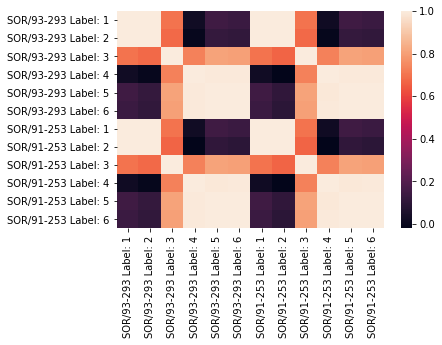

In [675]:
sns.heatmap(df_heatmap_label)

In [676]:
#
df_similar_regs_label_score.sort_values(by='Score', ascending=False)

,Label_A,Label_B,Score
6,SOR/93-293 Label: 4,SOR/91-253 Label: 4,0.999996
11,SOR/93-293 Label: 5,SOR/91-253 Label: 6,0.999943
17,SOR/91-253 Label: 5,SOR/91-253 Label: 6,0.999943
9,SOR/93-293 Label: 5,SOR/93-293 Label: 6,0.999943
13,SOR/93-293 Label: 6,SOR/91-253 Label: 5,0.999943
3,SOR/93-293 Label: 2,SOR/91-253 Label: 2,0.999896
2,SOR/93-293 Label: 2,SOR/91-253 Label: 1,0.999623
0,SOR/93-293 Label: 1,SOR/93-293 Label: 2,0.999623
1,SOR/93-293 Label: 1,SOR/91-253 Label: 2,0.999124
14,SOR/91-253 Label: 1,SOR/91-253 Label: 2,0.999124


In [680]:
# Comparing Individual Labels
Label_A = 'SOR/93-293 Label: 6'
Label_B = 'SOR/91-253 Label: 6'

Title_A = str(list(dataset[dataset['instrument_number'] == reg1]['title'])).strip('[]')
Title_B = str(list(dataset[dataset['instrument_number'] == reg2]['title'])).strip('[]')

print(Title_A + " " + Label_A)
print(list(df_similar_regs_label[df_similar_regs_label['Reg_Label']==Label_A]['Text']))
print("")
print(Title_B + " " + Label_B)
print(list(df_similar_regs_label[df_similar_regs_label['Reg_Label']==Label_B]['Text']))

'Regulations Respecting Zoning at Bagotville Airport' SOR/93-293 Label: 6
["'In order to minimize bird hazards to aviation, no owner or lessee of any lands in respect of which these Regulations apply shall permit those lands or any part thereof to be used as a site for'"]

'Regulations Respecting Zoning at Cold Lake Airport' SOR/91-253 Label: 6
["'In order to minimize bird hazards to aviation, no owner or occupier of any lands in respect of which these Regulations apply shall permit those lands or any part thereof to be used as a site for'"]


# Alex thoughts on next Steps 

In [ ]:
Taking all original text and converting to it 'stem synonym'

cleaning the 'Label 1's that only say 'In this regulation'

In [ ]:
Can this be more user friendly to use (as in a tool)?

Clustering instead of LSA on individual labels?

Highlighting key examples of inconsistent language and conflicts

In [ ]:
Highlight words that appear in one but not the other